# Estimating the frequency of a sine wave

In this notebook we will use a simple MLP to estimate the frequency of sine waves.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mj-will/intro2ml/blob/master/notebooks/regression-sine.ipynb)

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(font_scale=1.2)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

### Global parameters

We will be generating the data in this example so we will specifiy parameters for the data and the neural network

In [2]:
# data params
min_freq = 4.
max_freq = 10.
Nsignals = 10000

In [3]:
# network params
Nparams = 2      # number of parameters to estimate
max_epochs = 10
batch_size = 50

##  Data

The "labels" will be the parameters used to generate the signals and the data will be the signals. In this case we're going to use the **frequency** $f$ and **phase** $\theta$.

In [4]:
fs = 1024                      # sampling frequency
t = np.arange(0, 1., 1 / fs)   # time arrat

In [5]:
def gen_sine(t, frequency, phase=0.):
    "Generate a sinusoidal signal with a given frequeny and phase shift"
    return np.sin(2. * np.pi * frequency * t + phase)

In [6]:
# array of possible values
Y = np.array([np.random.uniform(0.1, max_freq, Nsignals), np.random.uniform(0., np.pi / 2., Nsignals)]).T
print(f'Shape of parameter array: {Y.shape}')

Shape of parameter array: (10000, 2)


In [7]:
# loop through parameters and generate sine waves
X = np.array([gen_sine(t, *y) for y in Y])
print(f'Shape of data array: {X.shape}')

Shape of data array: (10000, 1024)


### Check the data

It's always good to check the data you're loading from files or generating to make sure it makes sense. The training is heavily dependent on the quality of the data and problems in your data will be reflected in training.

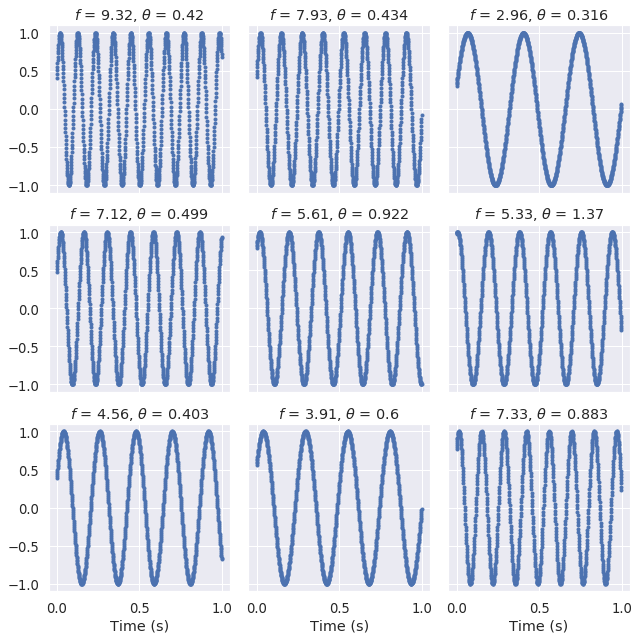

In [8]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9,9))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].plot(t, X[i], '.')
    axs[i].set_title(r'$f$ = {0:.3}, $\theta$ = {1:.3}'.format(Y[i,0], Y[i,1]))
for i in range(-3, 0):
    axs[i].set_xlabel('Time (s)')
plt.tight_layout()

### Shuffle and split the data

We shuffle the data and reserve part for testing the network once it is trained

In [9]:
# get a random set of indices
idx = np.random.permutation(Nsignals)
X, Y = X[idx], Y[idx]
split_idx = int(0.9 * Nsignals)
x_train, x_test = X[:split_idx], X[split_idx:]
y_train, y_test = Y[:split_idx], Y[split_idx:]
print(f'Training data shape - x: {x_train.shape}, y: {y_train.shape}')
print(f'Testing data shape - x: {x_test.shape}, y: {y_test.shape}')

Training data shape - x: (9000, 1024), y: (9000, 2)
Testing data shape - x: (1000, 1024), y: (1000, 2)


## The Model

We will again use a simple fully connected model but the activation function in the **output layer** will be different to the classification case.

When building a model for a new problem it is best to start of small. A very large network (number of trainable parameters) will struggle to learn anything from a very small dataset or may just memorise the dataset which is known as **overfitting**. Overfitting will be covered in more detail in another notebook.

In [10]:
model = Sequential()
model.add(Dense(256, input_shape=(len(t),), activation='relu'))
model.add(Dense(256, activation='relu'))
# single neuron in the output layer
model.add(Dense(Nparams, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 328,706
Trainable params: 328,706
Non-trainable params: 0
_________________________________________________________________


### Compile

The loss function used in **mean squared error**, since we are trying to minimize the difference between the predicted values  and the true values.

Different loss function will yield comparable results, this is something that is worth verifying.

In [11]:
model.compile(loss='mean_absolute_error',
              optimizer=Adam(lr=0.0001))

## Training

Start the training.

In [12]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8100 samples, validate on 900 samples
Epoch 1/10
8100/8100 [==============================] - 3s 427us/sample - loss: 0.5156 - val_loss: 0.0771
Epoch 2/10
8100/8100 [==============================] - 3s 330us/sample - loss: 0.0668 - val_loss: 0.0525
Epoch 3/10
8100/8100 [==============================] - 3s 315us/sample - loss: 0.0541 - val_loss: 0.0458
Epoch 4/10
8100/8100 [==============================] - 2s 281us/sample - loss: 0.0467 - val_loss: 0.0397
Epoch 5/10
8100/8100 [==============================] - 2s 284us/sample - loss: 0.0418 - val_loss: 0.0391
Epoch 6/10
8100/8100 [==============================] - 2s 283us/sample - loss: 0.0445 - val_loss: 0.0464
Epoch 7/10
8100/8100 [==============================] - 2s 289us/sample - loss: 0.0407 - val_loss: 0.0459
Epoch 8/10
8100/8100 [==============================] - 2s 288us/sample - loss: 0.0417 - val_loss: 0.0347
Epoch 9/10
8100/8100 [==============================] - 2s 295us/sample - loss: 0.0391 - val_loss: 0.0348

## Evaluation

As in the previous example we can now test the model on the unseen data

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: 0.05055534356832504


### Loss

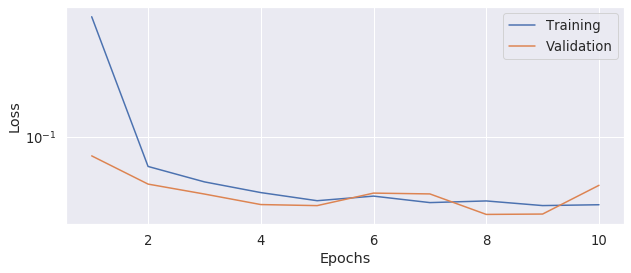

In [14]:
epochs = np.arange(1, max_epochs + 1, 1)
fig, plt.figure(figsize=(10,4))
plt.plot(epochs, history.history["loss"], label='Training')
plt.plot(epochs, history.history["val_loss"], label='Validation')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

plt.show()

### Predictions

We can also get the model to predit values for a given piece of data and compare this to the expected value

In [15]:
y_pred = model.predict(x_test)

If the predictions are exactly the true value we would expect a straight line. We actually see a line with some spread, the more spread the less accurate the predictions.

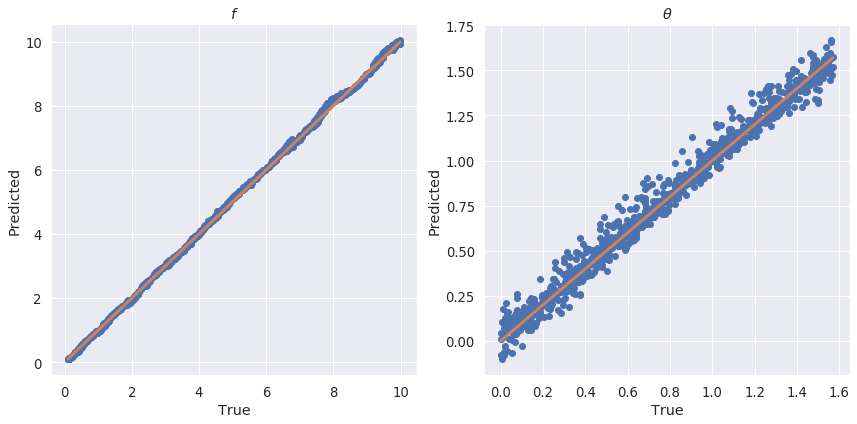

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].plot(y_test[:,i], y_pred[:,i], 'o')
    axs[i].plot([y_test[:,i].min(), y_test[:,i].max()], [y_test[:,i].min(), y_test[:,i].max()], 
                linewidth=3.0, alpha=0.9)
plt.tight_layout()
axs[0].set_title(r'$f$')
axs[1].set_title(r'$\theta$')
axs[0].set_xlabel('True')
axs[0].set_ylabel('Predicted')
axs[1].set_xlabel('True')
axs[1].set_ylabel('Predicted')
plt.tight_layout()
plt.show()